<a href="https://colab.research.google.com/github/hemoabdullah/PCVK_smst5/blob/main/Week6_Hammam_Abdullah.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import math
from google.colab.patches import cv2_imshow
from PIL import Image as im

### Convolution

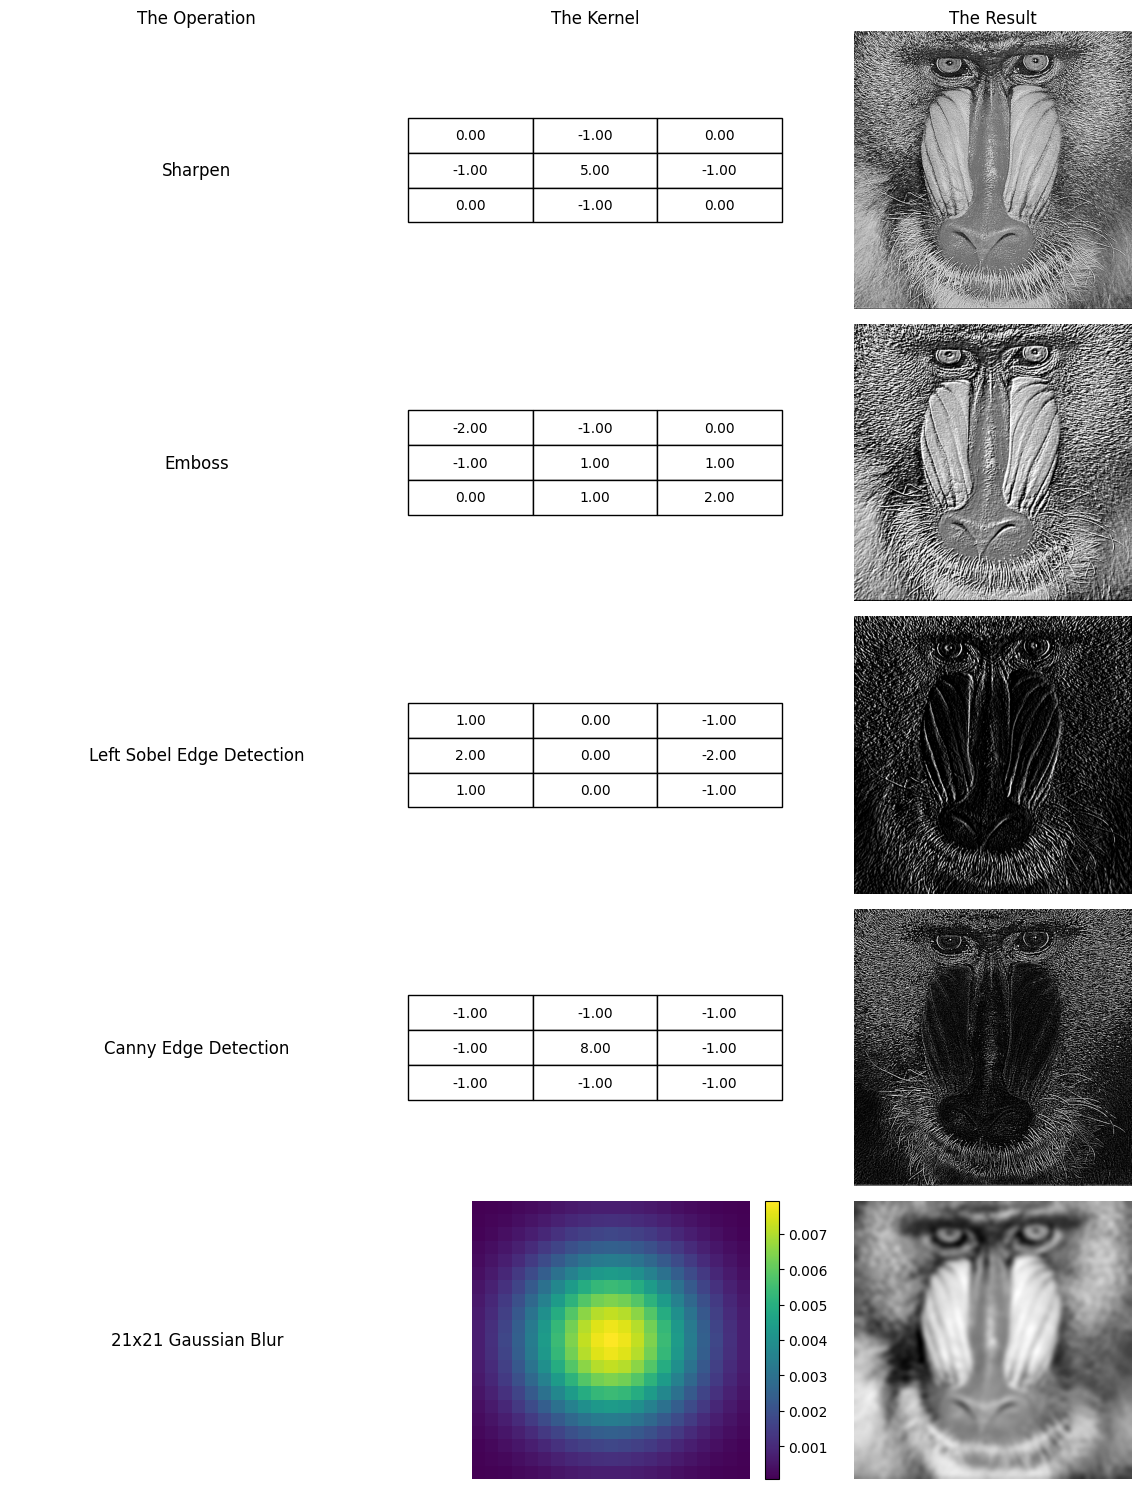

In [4]:
# Helper: convolution wrapper
def convolution2d(img, kernel):
    k = np.array(kernel, dtype=np.float32)
    return cv.filter2D(img, -1, k)


def plot_kernel(ax, kernel):
    k = np.array(kernel, dtype=np.float32)
    ax.axis("off")
    max_dim = max(k.shape)
    if k.size <= 25:

        cell_text = [[f"{val:.2f}" for val in row] for row in k]
        table = ax.table(cellText=cell_text, loc="center", cellLoc="center")
        table.scale(1, 1.5)
    else:
        im = ax.imshow(k, cmap="viridis", interpolation="nearest")
        ax.set_xticks([])
        ax.set_yticks([])
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

img_path = '/content/drive/MyDrive/PCVK/Images/mandrill.tiff'
img = cv.imread(img_path)
if img is None:
    raise FileNotFoundError(f"Cannot find image at: {img_path}")
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

kernelS = np.array([[0, -1,  0],
                    [-1, 5, -1],
                    [0, -1,  0]], dtype=np.float32)

kernelE = np.array([[-2, -1, 0],
                    [-1,  1, 1],
                    [0,   1, 2]], dtype=np.float32)

kernelLSED = np.array([[1, 0, -1],
                       [2, 0, -2],
                       [1, 0, -1]], dtype=np.float32)

kernelCED = np.array([[-1, -1, -1],
                      [-1,  8, -1],
                      [-1, -1, -1]], dtype=np.float32)

kernel_size = 21
sigma = math.sqrt(kernel_size)
g_col = cv.getGaussianKernel(kernel_size, sigma).astype(np.float32)
gauss_kernel = (g_col @ g_col.T).astype(np.float32)

sharpened     = convolution2d(img_gray, kernelS)
embossed      = convolution2d(img_gray, kernelE)
sobel_left    = convolution2d(img_gray, kernelLSED)
canny_like    = convolution2d(img_gray, kernelCED)
gaussian_blur = convolution2d(img_gray, gauss_kernel)

titles = ["Sharpen", "Emboss", "Left Sobel Edge Detection",
          "Canny Edge Detection", "21x21 Gaussian Blur"]

kernels = [kernelS, kernelE, kernelLSED, kernelCED, gauss_kernel]
results = [sharpened, embossed, sobel_left, canny_like, gaussian_blur]

n = len(results)
fig, axes = plt.subplots(nrows=n, ncols=3, figsize=(12, 3*n))

for i in range(n):
    # Column 0: Operation name
    ax0 = axes[i, 0]
    ax0.axis("off")
    ax0.text(0.5, 0.5, titles[i], fontsize=12, ha="center", va="center")
    if i == 0:
        ax0.set_title("The Operation")

    # Column 1: Kernel (table or heatmap)
    ax1 = axes[i, 1]
    plot_kernel(ax1, kernels[i])
    if i == 0:
        ax1.set_title("The Kernel")

    # Column 2: Result image
    ax2 = axes[i, 2]
    ax2.imshow(results[i], cmap="gray")
    ax2.axis("off")
    if i == 0:
        ax2.set_title("The Result")

plt.tight_layout()
plt.show()

### Experiment 1

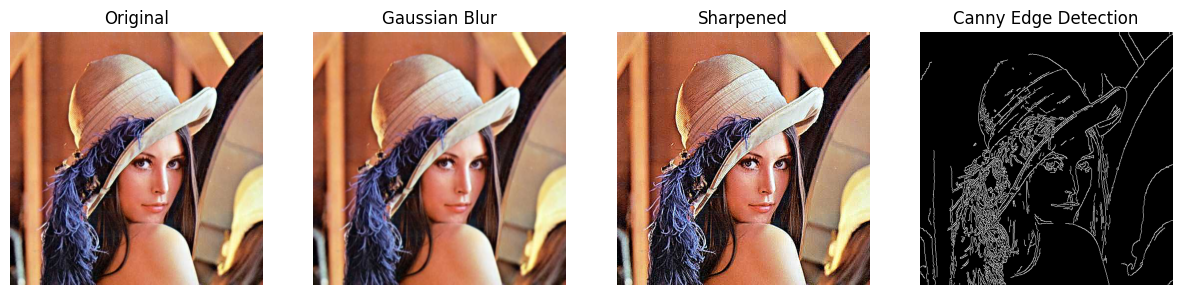

In [5]:
# Function to display images side by side
def show_side_by_side(images, titles, figsize=(15, 5)):
    plt.figure(figsize=figsize)
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), i + 1)

        # Check if image is grayscale or color
        if len(img.shape) == 2:
            plt.imshow(img, cmap="gray")
        else:
            plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

        plt.title(title)
        plt.axis("off")

    plt.show()


# Load image
img = cv.imread("/content/drive/MyDrive/PCVK/Images/lena.jpg")
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Apply Gaussian Blur
blur = cv.GaussianBlur(img, (7, 7), 1)

# Apply Canny Edge Detection
edges = cv.Canny(img_gray, 100, 200)

# Apply Sharpening filter
sharpen_kernel = np.array([[0, -1, 0],
                           [-1, 5, -1],
                           [0, -1, 0]])
sharpened = cv.filter2D(img, -1, sharpen_kernel)

# Show results side by side
show_side_by_side(
    [img, blur, sharpened, edges],
    ["Original", "Gaussian Blur", "Sharpened", "Canny Edge Detection"]
)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Experiment 2

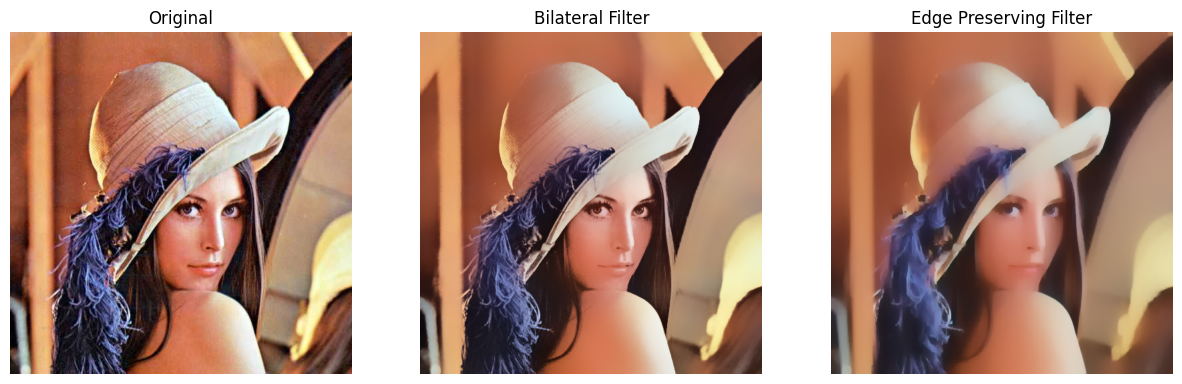

In [7]:
bilateral = cv.bilateralFilter(img, d=50, sigmaColor=100, sigmaSpace=100)

# Edge Preserving Filter (alternative to Guided Filter)
edge_preserve = cv.edgePreservingFilter(
    img, flags=1, sigma_s=100, sigma_r=0.9
)

# Show results side by side
show_side_by_side(
    [img, bilateral, edge_preserve],
    ["Original", "Bilateral Filter", "Edge Preserving Filter"]
)

### Experiment 3

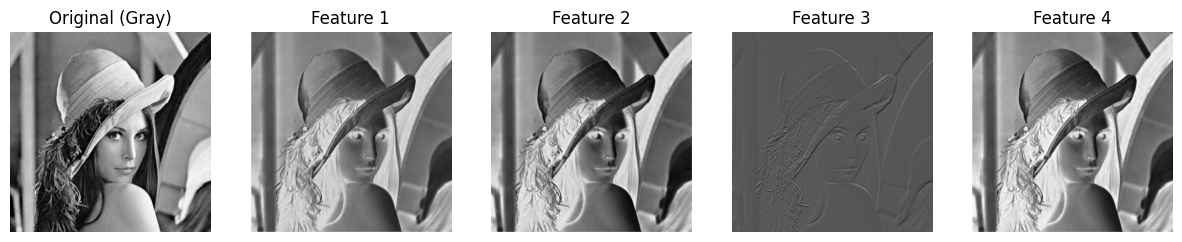

In [14]:
# Filter Feature Map use in CNN
import torch
import torch.nn as nn

# Simple CNN with one convolution layer
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        return self.conv1(x)

# Initialize model
model = SimpleCNN()

# Convert grayscale image to tensor
img_tensor = torch.tensor(img_gray, dtype=torch.float32).unsqueeze(0).unsqueeze(0) / 255.0

# Extract CNN feature maps (no gradient needed)
with torch.no_grad():
    features = model(img_tensor)

# Convert feature maps to numpy for visualization
feature_maps = [features[0, i].numpy() for i in range(features.shape[1])]

# Visualize feature maps
show_side_by_side(
    [img_gray] + feature_maps,
    ["Original (Gray)"] + [f"Feature {i+1}" for i in range(len(feature_maps))]
)

### Experiment 4

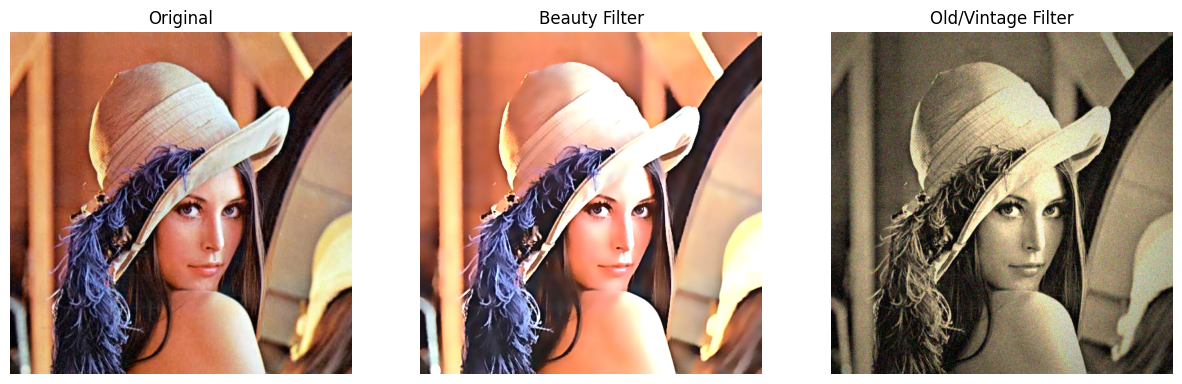

In [9]:
# ======================
# 1. Beauty Filter
# ======================
# Step 1: Smooth skin using bilateral filter
smooth = cv.bilateralFilter(img, d=15, sigmaColor=75, sigmaSpace=75)

# Step 2: Unsharp masking (enhance edges like eyes/lips)
gaussian = cv.GaussianBlur(smooth, (0,0), 3)
sharpened = cv.addWeighted(smooth, 1.5, gaussian, -0.5, 0)

# Step 3: Brightness & contrast
alpha = 1.2  # contrast
beta = 15    # brightness
beauty = cv.convertScaleAbs(sharpened, alpha=alpha, beta=beta)

# ======================
# 2. Old/Vintage Filter
# ======================
# Step 1: Sepia tone
sepia_kernel = np.array([[0.272, 0.534, 0.131],
                         [0.349, 0.686, 0.168],
                         [0.393, 0.769, 0.189]])
sepia = cv.transform(img, sepia_kernel)
sepia = np.clip(sepia, 0, 255).astype(np.uint8)

# Step 2: Vignette
rows, cols = img.shape[:2]
kernel_x = cv.getGaussianKernel(cols, cols*0.6)
kernel_y = cv.getGaussianKernel(rows, rows*0.6)
kernel = kernel_y * kernel_x.T
mask = kernel / kernel.max()
vignette = np.copy(sepia)
for i in range(3):
    vignette[:,:,i] = vignette[:,:,i] * mask

# Step 3: Noise/Grain
noise = np.random.normal(0, 15, vignette.shape).astype(np.int16)
old_img = np.clip(vignette.astype(np.int16) + noise, 0, 255).astype(np.uint8)

# Show side by side
show_side_by_side(
    [img, beauty, old_img],
    ["Original", "Beauty Filter", "Old/Vintage Filter"]
)

### Experiment 5

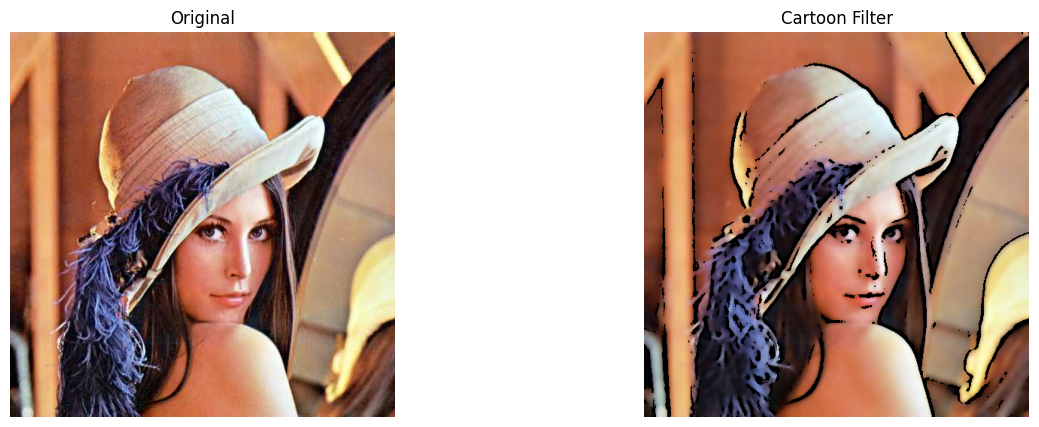

In [15]:
# Filter Anime / Cartoon
# Step 1: Edge detection (use median blur for smoother edges)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
gray_blur = cv.medianBlur(gray, 7)
edges = cv.adaptiveThreshold(gray_blur, 255,
                             cv.ADAPTIVE_THRESH_MEAN_C,
                             cv.THRESH_BINARY, 9, 9)

# Step 2: Bilateral filter for color smoothing
color = cv.bilateralFilter(img, d=9, sigmaColor=200, sigmaSpace=200)

# Step 3: Combine edges with smoothed color (cartoonize)
cartoon = cv.bitwise_and(color, color, mask=edges)

# Show result
show_side_by_side([img, cartoon], ["Original", "Cartoon Filter"])


### Experiment 6

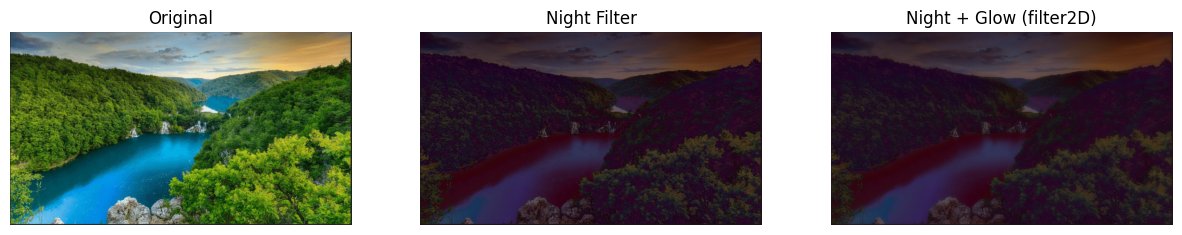

In [16]:
# Night Filter
img = cv.imread("/content/drive/MyDrive/PCVK/Images/jungle.png")
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Step 1: Darken (decrease contrast, negative brightness)
night = cv.convertScaleAbs(img, alpha=0.6, beta=-40)

# Step 2: Add blue bias
blue_tint = np.full_like(night, (50, 0, 100))  # BGR
night = cv.addWeighted(night, 0.8, blue_tint, 0.2, 0)

# Step 3: Glow effect in bright areas with 2D filters (blur kernel)
kernel = np.ones((15,15), np.float32) / 225
glow = cv.filter2D(night, -1, kernel)

# Combine original + glow
night_glow = cv.addWeighted(night, 0.7, glow, 0.3, 0)

show_side_by_side([img, night, night_glow],
                  ["Original", "Night Filter", "Night + Glow (filter2D)"])

### Experiment 7

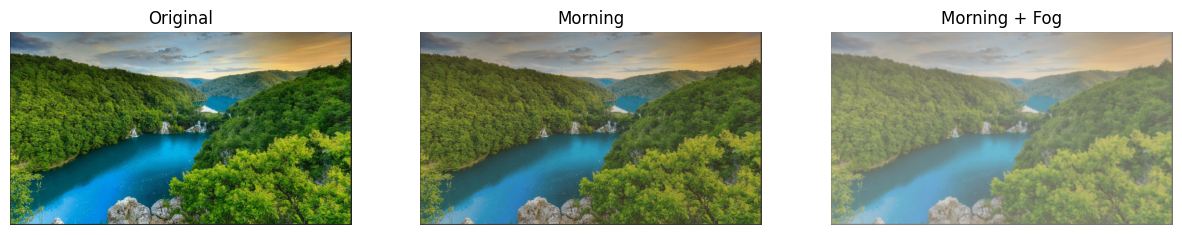

In [ ]:
# Morning and Fog Filter
# =============================
# Step 1: Reduce contrast & brighten
# =============================
alpha = 0.9   # contrast
beta = 20     # brightness
soft = cv.convertScaleAbs(img, alpha=alpha, beta=beta)

# =============================
# Step 2: Add warm tone (reddish / orange)
# =============================
warm_tint = np.full_like(soft, (40, 70, 120))  # BGR
pagi = cv.addWeighted(soft, 0.8, warm_tint, 0.2, 0)

# =============================
# Step 3: Add haze (thin fog) with filter2D
# =============================
# Gaussian-like kernel blur to create a haze effect
kernel = cv.getGaussianKernel(3, 3)
kernel = kernel @ kernel.T  # make it a 2D kernel
kabut = cv.filter2D(pagi, -1, kernel)

# add a white layer to make the haze more realistic
white_layer = np.full_like(pagi, 255)
kabut = cv.addWeighted(kabut, 0.7, white_layer, 0.3, 0)

show_side_by_side([img, pagi, kabut],
                  ["Original", "Morning", "Morning + Fog"])